# Model-based analysis of Reversal Learning

#### Korem et al., 2025?

This notebook performs a model-based analysis on a reversal learning task from the aging project dataset. The goal is to examine the effects of sex and aging on reward-based learning by comparing different value-updating models.

### Step 1: Modeling Behavior
We test the following models to analyze behavior during learning:

1. Single learning rate: A single parameter governing how the agent updates its expectations based on rewards.</br>
2. Valence model: Separate learning rates for positive and negative reward updating.</br>
3. Phases model: Separate learning rates for the acquisition and reversal phases.</br>
4. Valence and Phases model: Combines separate learning rates for positive/negative updating and the two task phases.</br>
5. Decay model: Adds a decay factor, simulating memory decay.</br>
6. Pierce-Hall model: A dynamic learning model based on attention and associative changes.</br>

### Step 2: Analyzing Age and Sex
We use the best-performing model from Step 1 to investigate the impact of age and sex on learning. Specifically, we test whether the learning rates differ across sex and age.

## Step 0: Load Libraries
We begin by importing the necessary libraries and reading in the dataset.

In [1]:
import pandas as pd
import numpy as np
import os

import learning_function

import matplotlib.pyplot as plt
import seaborn as sns

import pytensor.tensor as pt
from pytensor import scan

import pymc as pm
import arviz as az

# Suppressing warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

In [2]:
db = pd.read_csv('RW.csv')
db['Gender'] = np.where(db['gender'] == 'M', 1, 0)

# Extracting unique subjects and removing redundant columns
subs = db.drop_duplicates('sub')
subs = subs.drop(['trialNum', 'rectOri', 'rectValue', 'rating', 'RT'], axis=1).reset_index(drop=True)

n_subj   = len(db['sub'].unique())
print('Number of subjects:', n_subj)
n_trials = max(db.trialNum)

# Meshgrid for trials and subjects
trials, subj = np.meshgrid(range(n_trials), range(n_subj))
trial = (trials < 35) * 1  # Indicator for phases (acquisition/reversal)

# Convert data to tensors for modeling
stim   = np.reshape([db['rectOri']], (n_subj, n_trials)).T
reward = np.reshape([db['rectValue']], (n_subj, n_trials)).T
rating = np.reshape([db['rating']], (n_subj, n_trials)).T

stim   = np.array(stim / 45, dtype='int')
reward = np.array(reward / 6, dtype='int')
rating = np.where(rating == 0, np.nan, rating / 9)

stim_tensor = pt.as_tensor_variable(stim)
reward_tensor = pt.as_tensor_variable(reward)


Number of subjects: 70


## Step 1: Modeling Behavior

### Model 1: Bush-Mosteller Model (Single Learning Rate)
This model assumes that all updates to expected values are governed by a single learning rate parameter, α.

Bush, R. R., & Mosteller, F. (1953). A stochastic model with applications to learning. The Annals of Mathematical Statistics, 559-585.

In [3]:
%%time
with pm.Model() as model_sinle:

    # Hyper priors
    a1 = pm.TruncatedNormal('a1', 1, 1, lower=0)
    b1 = pm.TruncatedNormal('b1', 3, 1, lower=0)

    # Learning rate
    alpha = pm.Beta('alpha', a1, b1, shape=n_subj)
    # Observation noise
    eps = pm.Gamma('eps', 3, 1)
    
    As  = 0 * pt.ones((n_subj, 2), dtype='float64')
    vec = 0 * pt.ones((n_subj, 1), dtype='float64')
    
    [As, vec], _      = scan(  
        fn            = learning_function.update_single,
        sequences     = [stim_tensor, reward_tensor],
        outputs_info  = [As, vec],
        non_sequences = [alpha, n_subj]
    )
    
    vec_ = vec[trials, subj, 0]
    
    learn = pm.Normal('learn', mu=vec_, sigma=eps, observed=rating)
    
    ev = pm.Deterministic('expected_value', vec_)
    
    trace_single = pm.sample(nuts_sampler="blackjax", idata_kwargs={'log_likelihood':True})

CPU times: user 39.5 s, sys: 2.45 s, total: 42 s
Wall time: 18 s


### Model 2: Valence Model (Separate Learning Rates for Positive and Negative Updates)
This model introduces separate learning rates for positive and negative reward updates, allowing for asymmetry in learning.

Hopkins, A. K., Dolan, R., Button, K. S., & Moutoussis, M. (2021). A reduced self-positive belief underpins greater sensitivity to negative evaluation in socially anxious individuals. Computational psychiatry (Cambridge, Mass.), 5(1), 21.

In [4]:
%%time
with pm.Model() as model_valnece:

    # Hyper priors
    ap = pm.TruncatedNormal('ap', 1, 1, lower=0)
    bp = pm.TruncatedNormal('bp', 3, 1, lower=0)
    an = pm.TruncatedNormal('an', 1, 1, lower=0)
    bn = pm.TruncatedNormal('bn', 3, 1, lower=0)

    # Learning rate for positive and negative updates
    alpha_p = pm.Beta('alpha_p', ap, bp, shape=n_subj)
    alpha_n = pm.Beta('alpha_n', an, bn, shape=n_subj)
    
    eps = pm.Gamma('eps', 3,1)
    
    As  = 0 * pt.ones((n_subj, 2), dtype='float64')
    vec = 0 * pt.ones((n_subj, 1), dtype='float64')
    
    [As, vec], _ = scan(
        fn=learning_function.update_valence,
        sequences=[stim_tensor, reward_tensor],
        outputs_info=[As, vec],
        non_sequences=[alpha_p, alpha_n, n_subj]
    )
    
    vec_ = vec[trials, subj, 0]
    
    learn = pm.Normal('learn', mu=vec_, sigma=eps, observed=rating)
    
    ev = pm.Deterministic('expected_value', vec_)
    
    trace_valence = pm.sample(nuts_sampler="blackjax", idata_kwargs={'log_likelihood':True})

CPU times: user 1min 10s, sys: 495 ms, total: 1min 10s
Wall time: 28.4 s


### Model 3: Phases Model (Separate Learning Rates for Acquisition and Reversal Phases)
Here, we introduce separate learning rates for the acquisition and reversal phases of the task.

Daw, N. D. (2011). Trial-by-trial data analysis using computational models. Decision making, affect, and learning: Attention and performance XXIII, 23(1).

In [5]:
%%time
with pm.Model() as model_halves:

    # Hyper priors
    a1 = pm.TruncatedNormal('a1', 1, 1, lower=0)
    b1 = pm.TruncatedNormal('b1', 3, 1, lower=0)
    a2 = pm.TruncatedNormal('a2', 1, 1, lower=0)
    b2 = pm.TruncatedNormal('b2', 3, 1, lower=0)
    
    # Learning rate for acquisition and reversal
    alpha_1 = pm.Beta('alpha_1', a1, b1, shape=n_subj)
    alpha_2 = pm.Beta('alpha_2', a2, b2, shape=n_subj)
    
    eps = pm.Gamma('eps', 3, 1)
    
    As  = 0 * pt.ones((n_subj,2), dtype='float64')
    vec = 0 * pt.ones((n_subj,1), dtype='float64')
    
    [As, vec], updates = scan(
        fn            = learning_function.update_halves,
        sequences     = [stim, reward, trial],
        outputs_info  = [As, vec],
        non_sequences = [alpha_1, alpha_2,  n_subj])
   
    
    vec_ = vec[trials,subj,0]
    
    learn = pm.Normal('learn', vec_, eps, observed=rating) 
    
    # add matrix of expected values (trials X subjects)
    ev = pm.Deterministic('expected_value', vec_)
    
    trace_halves = pm.sample(nuts_sampler="blackjax", idata_kwargs={'log_likelihood':True})

CPU times: user 54.5 s, sys: 473 ms, total: 55 s
Wall time: 23.7 s


### Model 4: a combined model with separate learning rates for negative and positive updating and the different phases
Here, we introduce separate learning rates for the positive and negative updating as well as for the acquisition and reversal phases of the task.


In [6]:
%%time
with pm.Model() as model_valence_halves:

    # Hyper priors

    ap1 = pm.TruncatedNormal('ap1', 1, 1, lower=0)
    bp1 = pm.TruncatedNormal('bp1', 3, 1, lower=0)

    ap2 = pm.TruncatedNormal('ap2', 1, 1, lower=0)
    bp2 = pm.TruncatedNormal('bp2', 3, 1, lower=0)

    an1 = pm.TruncatedNormal('an1', 1, 1, lower=0)
    bn1 = pm.TruncatedNormal('bn1', 3, 1, lower=0)

    an2 = pm.TruncatedNormal('an2', 1, 1, lower=0)
    bn2 = pm.TruncatedNormal('bn2', 3, 1, lower=0)

    # Separate learning rates for each phase
    alphap_1 = pm.Beta('alphap_1', ap1, bp1, shape=n_subj)
    alphap_2 = pm.Beta('alphap_2', ap2, bp2, shape=n_subj)
    alphan_1 = pm.Beta('alphan_1', an1, bn1, shape=n_subj)
    alphan_2 = pm.Beta('alphan_2', an2, bn2, shape=n_subj)

    eps = pm.Gamma('eps', 3, 1)
    
    As  = 0 * pt.ones((n_subj,2), dtype='float64') # set values for boths stimuli (CS+, CS-)
    vec = 0 * pt.ones((n_subj,1), dtype='float64') # vector to save the relevant stimulus's expactation
    
    [As, vec], updates = scan(
        fn            = learning_function.update_valence_halves,
        sequences     = [stim, reward, trial],
        outputs_info  = [As, vec],
        non_sequences = [alphap_1, alphan_1, alphap_2, alphan_2,  n_subj])
   
    
    vec_ = vec[trials,subj,0] 
    
    learn = pm.Normal('learn', vec_, eps, observed=rating) 
    
    # add matrix of expected values (trials X subjects)
    ev = pm.Deterministic('expected_value', vec_)
    
    trace_valence_halves = pm.sample(nuts_sampler="blackjax", idata_kwargs={'log_likelihood':True})

CPU times: user 1min 50s, sys: 839 ms, total: 1min 51s
Wall time: 45.8 s


### Model 5: a model with a decay factor
In this model, we introduce a decay factor to account for the diminishing influence of older information over time, which helps improve belief updating in dynamic environments.

Nassar, M. R., Wilson, R. C., Heasly, B., & Gold, J. I. (2010). An approximately Bayesian delta-rule model explains the dynamics of belief updating in a changing environment. Journal of Neuroscience, 30(37), 12366-12378.

In [7]:
%%time
with pm.Model() as model_decay:

    # Hyper priors
    a1 = pm.TruncatedNormal('a1', 1, 1, lower=0)
    b1 = pm.TruncatedNormal('b1', 3, 1, lower=0)

    # Single learning rate and Decay factor
    alpha = pm.Beta('alpha', a1, b1, shape=n_subj) 
    decay = pm.Beta('decay', 1, 1, shape=n_subj)
    
    eps = pm.Gamma('eps', 3, 1)
    
    As  = 0 * pt.ones((n_subj,2), dtype='float64') # set values for boths stimuli (CS+, CS-)
    vec = 0 * pt.ones((n_subj,1), dtype='float64') # vector to save the relevant stimulus's expactation
    
    [As, vec], updates = scan(
        fn            = learning_function.update_decay,
        sequences     = [stim, reward],
        outputs_info  = [As, vec],
        non_sequences = [alpha, decay, n_subj])
   
    vec_ = vec[trials, subj, 0]
    
    learn = pm.Normal('learn', vec_, eps, observed = rating) 
    
    ev = pm.Deterministic('expected_value', vec_)
    
    trace_decay = pm.sample(nuts_sampler="blackjax", idata_kwargs={'log_likelihood':True})

CPU times: user 1min 1s, sys: 445 ms, total: 1min 1s
Wall time: 23.7 s


### Model 6: a counterfactual model
In this model, we introduce two learning rates: 1 for learning and one counterfactual.
Using separate learning rates for actual and counterfactual outcomes is important because learning from hypothetical scenarios (counterfactual learning) might be slower or different from learning from direct experiences. This model setup allows you to test whether individuals learn differently from rewards they receive versus rewards they might have missed.

Palminteri, S., Khamassi, M., Joffily, M., & Coricelli, G. (2015). Contextual modulation of value signals in reward and punishment learning. Nature Communications, 6, 8096. doi: 10.1038/ncomms9096

In [8]:
%%time
with pm.Model() as model_counterfactual:

    # Hyper priors for actual and counterfactual learning rates
    a1 = pm.TruncatedNormal('a1', 1, 1, lower=0)
    b1 = pm.TruncatedNormal('b1', 3, 1, lower=0)

    a2 = pm.TruncatedNormal('a2', 1, 1, lower=0)
    b2 = pm.TruncatedNormal('b2', 3, 1, lower=0)

    # Learning rate for actual (chosen) updates
    alpha = pm.Beta('alpha', a1, b1, shape=n_subj)

    # Learning rate for counterfactual (unchosen) updates
    alpha_counterfactual = pm.Beta('alpha_counterfactual', a2, b2, shape=n_subj)
    
    # Observation noise
    eps = pm.Gamma('eps', 3, 1)
    
    # Initialize As (value estimates) and vec (prediction error tracking)
    As  = 0 * pt.ones((n_subj, 2), dtype='float64')
    vec = 0 * pt.ones((n_subj, 1), dtype='float64')
    
    # Update As and vec using the counterfactual learning function with separate learning rates
    [As, vec], _ = scan(  
        fn            = learning_function.update_counterfactual,  # Use the counterfactual update function
        sequences     = [stim_tensor, reward_tensor],
        outputs_info  = [As, vec],
        non_sequences = [alpha, alpha_counterfactual, n_subj]
    )
    
    # Select the appropriate vector for each trial and subject
    vec_ = vec[trials, subj, 0]
    
    # Likelihood for observed data (ratings)
    learn = pm.Normal('learn', mu=vec_, sigma=eps, observed=rating)
    
    # Expected values over trials
    ev = pm.Deterministic('expected_value', vec_)
    
    # Sample from the posterior
    trace_counterfactual = pm.sample(nuts_sampler="blackjax", idata_kwargs={'log_likelihood':True})

CPU times: user 1min 21s, sys: 545 ms, total: 1min 22s
Wall time: 31.4 s


### Model 7: Pierce Hall model
This model employs a hybrid approach, assuming that the learning rate varies over time and is not constant, allowing for more flexible updates based on new information.

Homan, P., Levy, I., Feltham, E., Gordon, C., Hu, J., Li, J., ... & Schiller, D. (2019). Neural computations of threat in the aftermath of combat trauma. Nature Neuroscience, 22(3), 470-476.

In [9]:
%%time
with pm.Model() as model_PH:

    # Hyper priors
    a_kap = pm.TruncatedNormal('a_kap', 1, 1, lower=0)
    b_kap = pm.TruncatedNormal('b_kap', 100, 1, lower=0)

    # Eta represents the associability of a stimulus, determining how much attention is given to it for learning on a given trial. 
    # Kappa reflects the expected learning rate, 
    eta   = pm.Beta('eta',   1, 1, shape=n_subj)
    kappa = pm.Beta('kappa', a_kap, b_kap, shape=n_subj)

    eps = pm.Gamma('eps', 3, 1)
    
    As    = 0 * pt.ones((n_subj,2), dtype='float64') # set values for boths stimuli (CS+, CS-)
    vec   = 0 * pt.ones((n_subj,1), dtype='float64') # vector to save the relevant stimulus's expactation
    alpha = 0 * pt.ones((n_subj,2), dtype='float64') # vector to save the relevant stimulus's expactation
    assoc = 0 * pt.ones((n_subj,1), dtype='float64') # vector to save the relevant stimulus's expactation
    
    [As, vec, alpha, assoc], updates = scan(
        fn=learning_function.update_phall,
        sequences=[stim, reward],
        outputs_info=[As, vec, alpha, assoc],
        non_sequences=[eta, kappa, n_subj])
    
    vec_ = vec[trials, subj,0]

    learn = pm.Normal('learn', vec_, eps, observed = rating) 
    
    ev = pm.Deterministic('expected_value', vec_)
    
    trace_PH = pm.sample(nuts_sampler="blackjax", idata_kwargs={'log_likelihood':True})

CPU times: user 1min 35s, sys: 566 ms, total: 1min 36s
Wall time: 34.8 s


## Model comparison

In [10]:
models = {'Single learning': trace_single, 
          'Halves': trace_halves,
          'Valence': trace_valence,
          'Val-halves': trace_valence_halves,
          'Decay': trace_decay,
          'Counterfactual': trace_counterfactual,
          'PH': trace_PH
}

az.compare(models, ic='loo')

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
Counterfactual,0,-1681.888272,121.419684,0.000000,1.0,41.703439,0.000000,False,log
Valence,1,-2645.931034,83.315440,964.042763,0.0,45.340766,33.796153,False,log
Val-halves,2,-2649.443226,86.713087,967.554954,0.0,45.305220,33.776229,False,log
PH,3,-2877.153969,10.476271,1195.265697,0.0,44.338691,38.131916,False,log
Single learning,4,-3239.637871,21.284315,1557.749599,0.0,41.125442,37.996937,True,log
Halves,5,-3241.412402,22.359958,1559.524130,0.0,41.131729,37.999629,True,log
Decay,6,-3331.319513,25.743043,1649.431241,0.0,40.455956,38.405524,True,log


<AxesSubplot: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

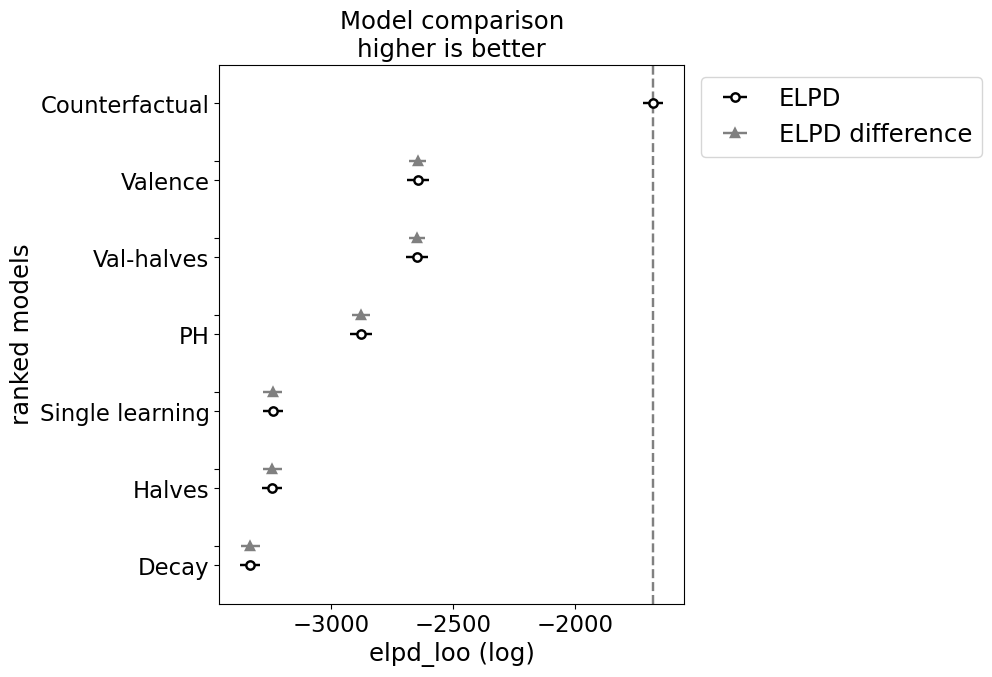

In [11]:
az.plot_compare(az.compare(models, ic='loo'))

Comparing the models, the Valence model demonstrated the best fit to the data, as indicated by the highest expected log predictive density (elpd_loo) of -2254.72 and a weight of 1.00.

This model outperformed all alternatives:</br>
1. the halves model - Valence had a stronger effect than reversal.</br>
2. The decay model - the diminished influence of older data was less pronounced in the data.</br>
3. Pierce-Hall hybrid model - A constant learning rate fit better than a dynamic one.</br>

Overall, the Valence model provides the most reliable predictions, with substantial evidence favoring its superiority.

## Step 2: Modeling Sex and Age

This step introduces models to investigate if participants's sex and age influence learning rates.</br>

#### data preparation 
Create lists for age (Z transform) and sex

In [12]:
ageList = db[['sub','age']].drop_duplicates()
ageList = (ageList['age'].values - ageList['age'].mean())/ageList['age'].std()

genderList = db[['sub','Gender']].drop_duplicates()
genderList = list(genderList['Gender'])

### Modeling Gender Using counterfactual learning model

In [13]:
%%time
with pm.Model() as model_counterfactual_gender:

    # Hyper priors for actual and counterfactual learning rates
    a1 = pm.TruncatedNormal('a1', 1, 1, lower=0)
    b1 = pm.TruncatedNormal('b1', 3, 1, lower=0)

    a2 = pm.TruncatedNormal('a2', 1, 1, lower=0)
    b2 = pm.TruncatedNormal('b2', 3, 1, lower=0)

    gender    = pm.Normal('gender',    0, 1)
    gender_cf = pm.Normal('gender_cf', 0, 1)
    
    # Learning rate for actual (chosen) updates
    alpha = pm.Beta('alpha', a1, b1, shape=n_subj)

    # Learning rate for counterfactual (unchosen) updates
    alpha_counterfactual = pm.Beta('alpha_counterfactual', a2, b2, shape=n_subj)

    a_g   = alpha + gender * genderList
    a_gcf = alpha_counterfactual + gender_cf * genderList
    
    # Observation noise
    eps = pm.Gamma('eps', 3, 1)
    
    # Initialize As (value estimates) and vec (prediction error tracking)
    As  = 0 * pt.ones((n_subj, 2), dtype='float64')
    vec = 0 * pt.ones((n_subj, 1), dtype='float64')
    
    # Update As and vec using the counterfactual learning function with separate learning rates
    [As, vec], _ = scan(  
        fn            = learning_function.update_counterfactual,  # Use the counterfactual update function
        sequences     = [stim_tensor, reward_tensor],
        outputs_info  = [As, vec],
        non_sequences = [a_g, a_gcf, n_subj]
    )
    
    # Select the appropriate vector for each trial and subject
    vec_ = vec[trials, subj, 0]
    
    # Likelihood for observed data (ratings)
    learn = pm.Normal('learn', mu=vec_, sigma=eps, observed=rating)
    
    # Expected values over trials
    ev = pm.Deterministic('expected_value', vec_)
    
    # Sample from the posterior
    trace_counterfactual_gender = pm.sample(nuts_sampler="blackjax", idata_kwargs={'log_likelihood':True},draws=2000)

CPU times: user 2min 52s, sys: 998 ms, total: 2min 53s
Wall time: 57.9 s


In [14]:
az.summary(trace_counterfactual_gender, var_names=['gender', 'gender_cf'], hdi_prob=.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
gender,0.081,0.014,0.059,0.103,0.000,0.0,939.0,2823.0,1.01
gender_cf,0.086,0.019,0.056,0.116,0.001,0.0,920.0,2095.0,1.00


The model results suggest a notable difference in learning rates between genders, with men showing an average increase of 0.081 in the learning rate and 0.086 in counterfactual learning.


### Modeling age Using counterfactual learning

In [15]:
%%time
with pm.Model() as model_counterfactual_age:

    # Hyper priors for actual and counterfactual learning rates
    a1 = pm.TruncatedNormal('a1', 1, 1, lower=0)
    b1 = pm.TruncatedNormal('b1', 3, 1, lower=0)

    a2 = pm.TruncatedNormal('a2', 1, 1, lower=0)
    b2 = pm.TruncatedNormal('b2', 3, 1, lower=0)

    age    = pm.Normal('age',    0, 1)
    age_cf = pm.Normal('age_cf', 0, 1)
    
    # Learning rate for actual (chosen) updates
    alpha = pm.Beta('alpha', a1, b1, shape=n_subj)

    # Learning rate for counterfactual (unchosen) updates
    alpha_counterfactual = pm.Beta('alpha_counterfactual', a2, b2, shape=n_subj)

    a_a  = alpha + age * ageList
    a_acf = alpha_counterfactual + age_cf * ageList
    
    # Observation noise
    eps = pm.Gamma('eps', 3, 1)
    
    # Initialize As (value estimates) and vec (prediction error tracking)
    As  = 0 * pt.ones((n_subj, 2), dtype='float64')
    vec = 0 * pt.ones((n_subj, 1), dtype='float64')
    
    # Update As and vec using the counterfactual learning function with separate learning rates
    [As, vec], _ = scan(  
        fn            = learning_function.update_counterfactual,  # Use the counterfactual update function
        sequences     = [stim_tensor, reward_tensor],
        outputs_info  = [As, vec],
        non_sequences = [a_a, a_acf, n_subj]
    )
    
    # Select the appropriate vector for each trial and subject
    vec_ = vec[trials, subj, 0]
    
    # Likelihood for observed data (ratings)
    learn = pm.Normal('learn', mu=vec_, sigma=eps, observed=rating)
    
    # Expected values over trials
    ev = pm.Deterministic('expected_value', vec_)
    
    # Sample from the posterior
    trace_counterfactual_age = pm.sample(nuts_sampler="blackjax", idata_kwargs={'log_likelihood':True},draws=2000)

CPU times: user 4min 4s, sys: 896 ms, total: 4min 5s
Wall time: 2min 16s


In [16]:
az.summary(trace_counterfactual_age, var_names=['age', 'age_cf'], hdi_prob=.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
age,-0.001,0.015,-0.025,0.023,0.001,0.0,754.0,1796.0,1.01
age_cf,-0.003,0.017,-0.029,0.025,0.001,0.0,1136.0,1793.0,1.00


In [17]:
%load_ext watermark
%watermark -n -u -v -iv -w -p xarray

Last updated: Thu Sep 19 2024

Python implementation: CPython
Python version       : 3.11.0
IPython version      : 8.20.0

xarray: 2023.6.0

numpy     : 1.23.5
pytensor  : 2.25.2
pandas    : 1.5.3
seaborn   : 0.12.2
matplotlib: 3.6.3
pymc      : 5.16.2
arviz     : 0.17.1

Watermark: 2.4.3

